In [1]:
#Reference: https://bioconductor.org/packages/release/bioc/vignettes/ChAMP/inst/doc/ChAMP.html#section-description-of-champ-pipelines
library("lumi") #beta2m
library("ChAMP") #pipeline
#https://bioconductor.org/packages/devel/bioc/vignettes/methylGSA/inst/doc/methylGSA-vignette.html
#library("methylGSA")
library("xlsx") #metadata
options(warn=-1)

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with


In [2]:
#define where the data is
idat_dir = "/blue/raquel.dias/Ishan/Methylation/data/merged"
#idat_files = dir(path = idat_dir, pattern="idat", full.names = TRUE)
#bpm_files = dir(path = idat_dir, pattern="bpm", full.names = TRUE)
sample_files = dir(path = idat_dir, pattern="Samples.*xlsx", full.names = TRUE)
sample_sheets = dir(path = idat_dir, pattern="Sample Sheet.csv", full.names = TRUE)


In [3]:
#load sample information (case/control info, etc)
sample_data <- read.xlsx(sample_files[1], sheetIndex = 1)
names(sample_data) <- gsub("\\.","_",names(sample_data))

print(sample_files)

#if there are more batches, but all batches in the same folder and run the code bellow
if(length(sample_files)>1){
    for(i in 2:length(sample_files)){
        sample_data <- cbind(sample_data, read.xlsx(sample_files[i]))
    }
}

#load sample IDs that can mapped to idat file names
if(length(sample_sheets)>0){
    sample_ids <- read.csv(sample_sheets[1], skip=7)
    print(sample_sheets)
    print(sample_ids$Sample_Name)
    #if there are more batches, but all batches in the same folder and run the code bellow
    if(length(sample_sheets)>1){
        for(i in 2:length(sample_sheets)){
            tmp_data <- read.csv(sample_sheets[i], skip=7)
            names(tmp_data) <- gsub("\\.","_",names(tmp_data))
            sample_ids <- rbind(sample_ids, tmp_data)
        }
    }
}else{
    sample_ids <- read.csv(paste0(idat_dir,"/merged_sample_sheet.csv"))
    
}

sample_ids$Sample_Name
#map sample IDs to illumina IDs
if(length(sample_sheets)>0){
    sample_data_merged <- merge(sample_ids, sample_data, by.x="Sample_Name", by.y="External_study_ID")
    write.table(file=paste0(idat_dir,"/merged_sample_sheet.csv"), sample_data_merged, sep=',', col.names=TRUE, row.names=FALSE, quote=TRUE)
    for(i in sample_sheets){
        new_name=gsub("\\.csv$", "\\.old", i)
        file.rename(i, new_name)
    }    
}else{
    sample_data_merged <- sample_ids
}

[1] "/blue/raquel.dias/Ishan/Methylation/data/merged/DNA Methelyation Samples export_112921_Bhatt_11_30_2022.xlsx"


[1] "U1154" "U12"   "U132"  "U133"  "U1343" "U144"  "U156"  "U16"   "U167" 
[10] "U175"  "U181"  "U183"  "U201"  "U203"  "U220"  "U226"  "U229"  "U234" 
[19] "U247"  "U247"  "U26"   "U28"   "U302"  "U315"  "U336"  "U344"  "U354" 
[28] "U376"  "U4"    "U41"   "U45"   "U503"  "U527"  "U54"   "U541"  "U568" 
[37] "U585"  "U595"  "U63"   "U64"   "U654"  "U711"  "U712"  "U789"  "U83"  
[46] "U845"  "U86"   "U869"

In [4]:
tail(sample_data_merged)

Sample_Name Sample_Well Sample_Plate Sample_Group Pool_ID Sentrix_ID  
43 U712        G2          NA           NA           NA      205689130086
44 U789        E4          NA           NA           NA      205852200157
45 U83         H1          NA           NA           NA      205689130080
46 U845        B1          NA           NA           NA      205852200117
47 U86         B3          NA           NA           NA      205852200128
48 U869        E3          NA           NA           NA      205852200128
   Sentrix_Position X_ Sample_Folder           Sample_Name.y  ⋯
43 R07C01           47 DNA Methylation Samples 20210035_1_b.2 ⋯
44 R05C01           29 DNA Methylation Samples 20210036_1_a.2 ⋯
45 R08C01           40 DNA Methylation Samples 20210006_1_a.2 ⋯
46 R02C01            2 DNA Methylation Samples 20210025_1_a.2 ⋯
47 R02C01           18 DNA Methylation Samples 20210008_1_a.2 ⋯
48 R05C01           21 DNA Methylation Samples 20210038_1_a.2 ⋯
   concentration__ng_ul_ Qubit_Conc__Reading__ng_ul_ After_dilution__ng_ul_
43 165                    5.67                        56.7                 
44  47                    3.88                        38.8                 
45 240                   12.60                       126.0                 
46 149                   11.70                       117.0                 
47 714                   41.00                       410.0                 
48 119                    4.48                        44.8                 
   DNA_vol___ul_ Water_vol___ul_ Total_volume case    Plate_Position Plate__
43 22.045855      90.45414       112.5        Case    2G             Plate 2
44 32.216495      80.28351       112.5        Case    4E             Plate 1
45  9.920635     102.57937       112.5        Control 1H             Plate 2
46 10.683761     101.81624       112.5        Control 1B             Plate 1
47  3.048780     109.45122       112.5        Control 3B             Plate 1
48 27.901786      84.59821       112.5        Case    3E             Plate 1
   batch_id
43 0       
44 1       
45 0       
46 1       
47 1       
48 1

# Import, preprocess and filter the raw idat files
Used champ.load() to compute the methylation signals and failed fractions
## Default recommended filtering criteria used:
- method="ChAMP": default analysis method (faster and more robust than old version)
- methValue="B": results return beta values
- methValue="M": results return M values
- filterBeads=TRUE: probes with a beadcount less than 3 were removed depending on the beadCutoff value.
- filterDetP=TRUE and ProbeCutoff=0: The NA ratio threshhold for probes was zero. Probes above threshold were removed.
- detPcut=0.01: probes with a detection p-value larger than 0.01 where removed
- SampleCutoff=0.1: The failed p value (or NA) threshhold for samples was 0.10. Samples with above proportion of failed p value (NA) will be removed.
- beadCutoff=0.05: 0.05 as the fraction of samples that must have a beadcount less than 3 before the probe is removed
- filterNoCG=TRUE: non-cg probes were removed
- population=NULL: no specific population filtering assigned
- filterMultiHit=TRUE: probes in which the probe aligns to multiple locations with bwa as defined in Nordlund et al were removed
- filterXY=TRUE: probes from X and Y chromosomes were removed
- autoimpute=TRUE: imputation enabled

## Non-default options used:
- Array type: EPIC
- filterSNPs=FALSE: probes in which the probed CpG falls near a SNP as defined in Nordlund et al were not removed.

In [5]:
myLoad <- champ.load(directory = idat_dir,
           method="ChAMP",
           methValue="B",
           autoimpute=TRUE, #default TRUE
           filterDetP=TRUE,
           ProbeCutoff=0,
           SampleCutoff=0.1,
           detPcut=0.01,
           filterBeads=TRUE,
           beadCutoff=0.05,
           filterNoCG=TRUE,
           filterSNPs=FALSE, #default TRUE
           population=NULL,
           filterMultiHit=TRUE,
           filterXY=TRUE,
           force=FALSE,
           arraytype="EPIC")


[===========================]

[<<<< ChAMP.LOAD START >>>>>]

-----------------------------


[ Loading Data with ChAMP Method ]

----------------------------------

Note that ChAMP method will NOT return rgSet or mset, they object defined by minfi. Which means, if you use ChAMP method to load data, you can not use SWAN or FunctionNormliazation method in champ.norm() (you can use BMIQ or PBC still). But All other function should not be influenced.


[===========================]

[<<<< ChAMP.IMPORT START >>>>>]

-----------------------------


[ Section 1: Read PD Files Start ]

  CSV Directory: /blue/raquel.dias/Ishan/Methylation/data/merged/merged_sample_sheet.csv

  Find CSV Success

  Reading CSV File

  Replace Sentrix_Position into Array

  Replace Sentrix_ID into Slide

[ Section 1: Read PD file Done ]



[ Section 2: Read IDAT files Start ]

  Loading:/blue/raquel.dias/Ishan/Methylation/data/merged/205852200117_R01C01_Grn.idat ---- (1/48)

  Loading:/blue/raquel.dias/Ishan/Meth

      Failed CpG Fraction.
U1154         0.0004203631
U12           0.0009273395
U132          0.0003787888
U133          0.0016468072
U1343         0.0009250299
U144          0.0011086500
U156          0.0003533822
U16           0.0007795195
U167          0.0007714356
U175          0.0007448742
U181          0.0007760550
U183          0.0004030405
U201          0.0007471839
U203          0.0007483388
U220          0.0003695500
U226          0.0016572008
U229          0.0007598872
U234          0.0007645066
U247          0.0007587324
U247          0.0004215180
U26           0.0007425645
U28           0.0007090741
U302          0.0004503891
U315          0.0004965828
U336          0.0007171580
U344          0.0007379452
U354          0.0004203631
U376          0.0004122792
U4            0.0007044547
U41           0.0012599345
U45           0.0007448742
U503          0.0007275516
U527          0.0004122792
U54           0.7327772376
U541          0.0004665569
U568          0.0007899131
U


    The detSamplecut parameter is : 0.1

    Samples : U54 will be deleted.

    There are 47 samples remained for analysis.


    Filtering probes with a detection p-value above 0.01.

    Removing 6083 probes.

    If a large number of probes have been removed, ChAMP suggests you to identify potentially bad samples


  Filtering BeadCount Start

    Filtering probes with a beadcount <3 in at least 5% of samples.

    Removing 11762 probes


  Filtering NoCG Start

    Only Keep CpGs, removing 2959 probes from the analysis.


  Filtering MultiHit Start

    Filtering probes that align to multiple locations as identified in Nordlund et al

    Removing 8456 probes from the analysis.


  Filtering XY Start

    Filtering probes located on X,Y chromosome, removing 18670 probes from the analysis.


  Updating PD file


  Fixing Outliers Start

    Replacing all value smaller/equal to 0 with smallest positive value.

    Replacing all value greater/equal to 1 with largest value below 1..


In [6]:
str(myLoad)

List of 3
 $ beta     : num [1:817988, 1:47] 0.7599 0.8143 0.7685 0.0289 0.6391 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:817988] "cg07881041" "cg23229610" "cg03513874" "cg05451842" ...
  .. ..$ : chr [1:47] "U1154" "U12" "U132" "U133" ...
 $ intensity: int [1:817988, 1:47] 8847 4128 5995 9698 6268 6640 9129 13218 7976 8103 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:817988] "cg07881041" "cg23229610" "cg03513874" "cg05451842" ...
  .. ..$ : chr [1:47] "U1154" "U12" "U132" "U133" ...
 $ pd       :'data.frame':	47 obs. of  22 variables:
  ..$ Sample_Name                : chr [1:47] "U1154" "U12" "U132" "U133" ...
  ..$ Sample_Well                : chr [1:47] "A1" "H3" "A2" "H1" ...
  ..$ Sample_Plate               : logi [1:47] NA NA NA NA NA NA ...
  ..$ Sample_Group               : logi [1:47] NA NA NA NA NA NA ...
  ..$ Pool_ID                    : logi [1:47] NA NA NA NA NA NA ...
  ..$ Slide                      : num [1:47] 2.06e+11 2.06e+11 2.06e+11 2

# Plot QC information

- mdsPlot (Multidimensional Scaling Plot): This plot allows a visualization of the similarity of samples based on the top 1000 most variable probes amongst all samples. Samples are colored by Sample Groups in this plot.
- densityPlot: The beta distributions for each sample; users may use this figure to find samples which deviate significantly from others and which may not be of good quality (e.g. incomplete bisulfite conversion). NB: It also serves to identify and confirm methylated or unmethylated control samples, if these were included in the study).
- dendrogram: The clustering plot for all samples, you may select different method to generate this plot. There is a parameter Feature.sel="None" in champ.QC() function. While “None” means the distance between samples would be calculated directly by all probes (your server may crash if you directly do this on a large data set), “SVD” means champ.QC() function would use SVD method to do deconvolute on beta matrix, then select significant components based only EstDimRMT() method from “isva” package. Then the distance between samples would be calculated based on these components.


[===========================]

[<<<<< ChAMP.QC START >>>>>>]

-----------------------------

champ.QC Results will be saved in ./CHAMP_QCimages/

[QC plots will be proceed with 817988 probes and 47 samples.]


<< Prepare Data Over. >>

<< plot mdsPlot Done. >>


<< Plot densityPlot Done. >>


[<<<<<< ChAMP.QC END >>>>>>>]

[===========================]

[You may want to process champ.norm() next.]




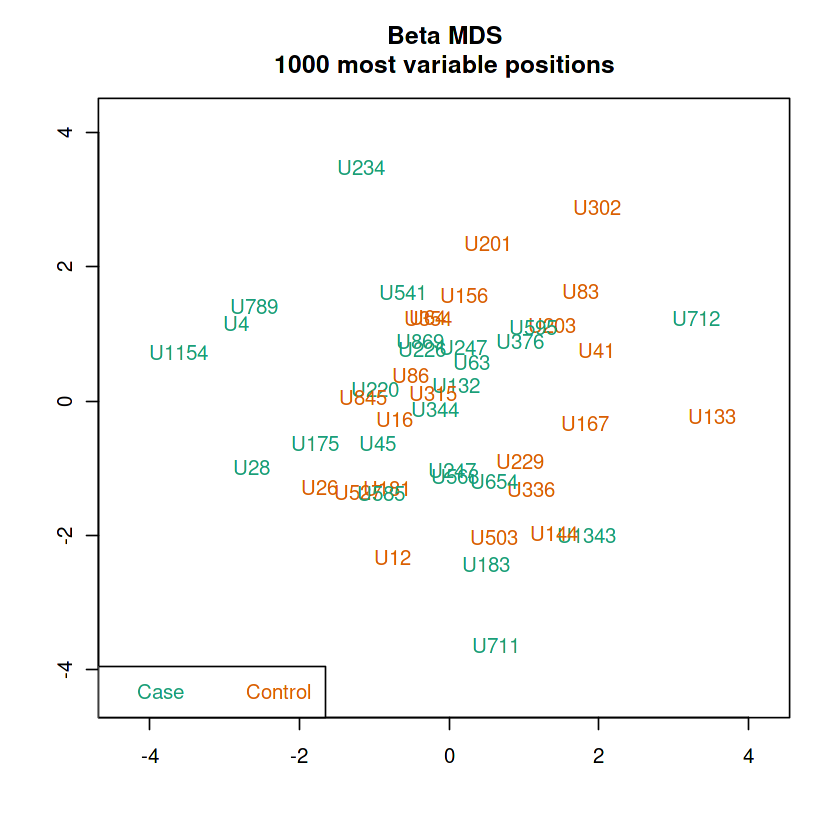

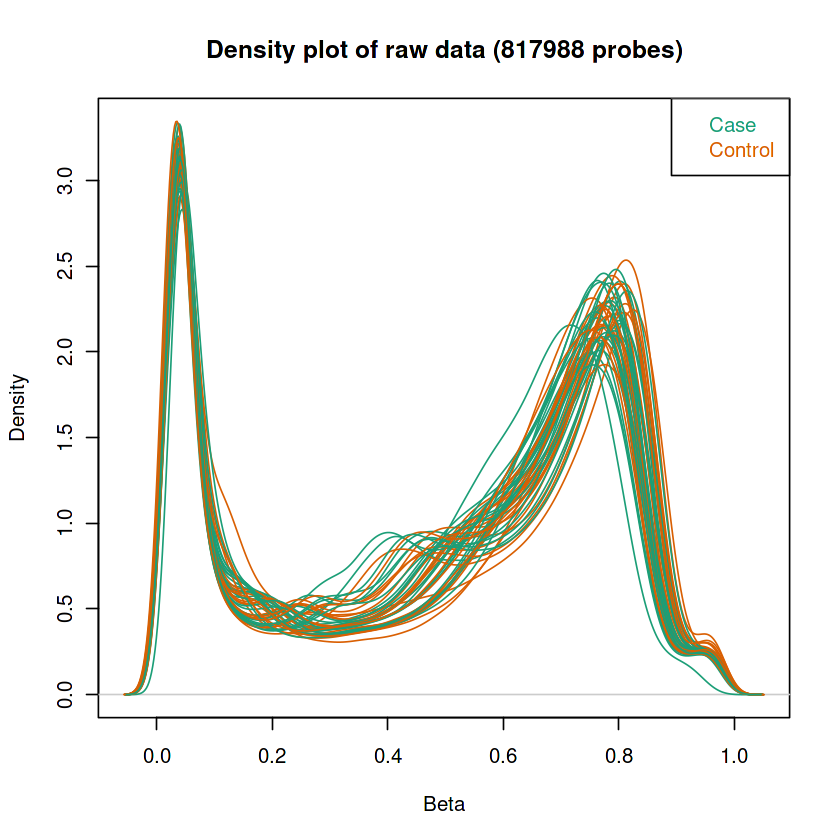

In [7]:
#merged_data <- merge(myLoad$pd, sample_data_merged, by="Sample_Name")
myLoad$pd$Sample_Group <- myLoad$pd$case

champ.QC(beta = myLoad$beta,
         pheno=myLoad$pd$Sample_Group,
         mdsPlot=TRUE,
         densityPlot=TRUE,
         dendrogram=FALSE, #made for small arrays, None and SVD crashes with too many features
         PDFplot=TRUE,
         Rplot=TRUE,
         Feature.sel="None",
         resultsDir="./CHAMP_QCimages/")

In [8]:
write.table(myLoad$pd, file = "sample_data_mapped.csv", sep=",", row.names=FALSE, col.names=TRUE, quote = FALSE)

# Normalization
In champ.norm(), we provide four methods to do this type-II probe normalization: BMIQ3, SWAN1, PBC2 and FunctionalNormliazation4.
Note that the BMIQ function should provide better normalization for EPIC array data. We note that BMIQ may not converge and provide output for certain samples, and this may happen if the methylation distribution of the sample deviates markedly from a 3-state beta-mixture distribution (as it may happen for methylated/unmethylated controls), or because of poor sample quality.

In [9]:
myNorm <- champ.norm(beta=myLoad$beta,
#               rgSet=myLoad$rgSet,
#               mset=myLoad$mset,
               resultsDir="./CHAMP_Normalization/",
               method="BMIQ",
               plotBMIQ=TRUE,
               arraytype="EPIC",
               cores=8)
write.table(myNorm, file = "Normalized_data.csv", sep=",", row.names=FALSE, col.names=TRUE, quote = FALSE)

[===========================]

[>>>>> ChAMP.NORM START <<<<<<]

-----------------------------

champ.norm Results will be saved in ./CHAMP_Normalization/

[ SWAN method call for BOTH rgSet and mset input, FunctionalNormalization call for rgset only , while PBC and BMIQ only needs beta value. Please set parameter correctly. ]


<< Normalizing data with BMIQ Method >>

Note that,BMIQ function may fail for bad quality samples (Samples did not even show beta distribution).

8 cores will be used to do parallel BMIQ computing.

[>>>>> ChAMP.NORM END <<<<<<]

[===========================]

[You may want to process champ.SVD() next.]




In [10]:
head(myNorm)

U1154      U12        U132       U133       U1343      U144      
cg07881041 0.94430159 0.95397389 0.94099176 0.97435039 0.94086699 0.94804491
cg23229610 0.97152481 0.96027407 0.96907504 0.95775964 0.97897142 0.95805904
cg03513874 0.94919859 0.94693237 0.93653439 0.97317178 0.97112629 0.95383118
cg05451842 0.01141404 0.02139034 0.01907629 0.02209235 0.02697896 0.01140523
cg14797042 0.82424398 0.62822542 0.83975074 0.88325248 0.82922111 0.70793557
cg09838562 0.01018662 0.02977113 0.01555324 0.02797240 0.01532635 0.01480617
           U156       U16        U167       U175       ⋯ U63        U64       
cg07881041 0.94169778 0.95294719 0.93904693 0.93710196 ⋯ 0.97269944 0.93958935
cg23229610 0.96292628 0.95218295 0.92694120 0.96849146 ⋯ 0.95129121 0.97240431
cg03513874 0.94474707 0.93808742 0.88844620 0.96253071 ⋯ 0.95758330 0.94633924
cg05451842 0.01544799 0.01612866 0.01649565 0.01729389 ⋯ 0.01724142 0.01446069
cg14797042 0.88461897 0.71504158 0.08854319 0.86612296 ⋯ 0.84415627 0.71021701
cg09838562 0.02022256 0.02140131 0.01188767 0.01367064 ⋯ 0.03364702 0.02063763
           U654       U711       U712       U789       U83        U845      
cg07881041 0.92767262 0.95085641 0.95185898 0.91774378 0.95827585 0.93626713
cg23229610 0.95055588 0.96034728 0.96084026 0.95239692 0.98332873 0.98265052
cg03513874 0.94432012 0.93923561 0.93585339 0.95286034 0.96589934 0.93408696
cg05451842 0.01716827 0.02023214 0.01031745 0.01290116 0.01159780 0.01547102
cg14797042 0.71058905 0.72477002 0.64512684 0.90863133 0.85741519 0.92273618
cg09838562 0.01281392 0.01670472 0.02408735 0.01570555 0.02025704 0.01766577
           U86        U869      
cg07881041 0.91600651 0.94931251
cg23229610 0.97515024 0.95481520
cg03513874 0.93987584 0.93974917
cg05451842 0.02582975 0.02124212
cg14797042 0.67016290 0.61752743
cg09838562 0.01990012 0.01652959

# Singular Value Decomposition method (SVD)
This will be executed later to identify batch effects when we have more batches

The singular value decomposition method (SVD) implemented by Teschendorff for methylation data is a powerful tool for assessing the number and nature of the significant components of variation in a dataset. These components of variation would ideally correlate with biological factors of interest, but generally also correlate with technical sources of variation (e.g. batch effects). 

[===========================]

[<<<<< ChAMP.SVD START >>>>>]

-----------------------------

champ.SVD Results will be saved in ./CHAMP_SVDimages/ .


[SVD analysis will be proceed with 817988 probes and 47 samples.]



[ champ.SVD() will only check the dimensions between data and pd, instead if checking if Sample_Names are correctly matched (because some user may have no Sample_Names in their pd file),thus please make sure your pd file is in accord with your data sets (beta) and (rgSet).]


<< Following Factors in your pd(sample_sheet.csv) will be analysised: >>

<Sample_Well>(character):A1, H3, A2, H1, G1, H4, D2, F4, F2, E1, B4, C3, B2, C2, G2, D4, C4, F1, D1, D3, B1, E2, H2, A4, A3, G4, C1, F3, G3, E4, B3, E3

<Sample_Group>(character):Case, Control

<Slide>(numeric):205852200117, 205852200128, 205852200126, 205689130080, 205852200157, 205689130086

<Array>(character):R01C01, R08C01, R07C01, R04C01, R06C01, R05C01, R02C01, R03C01

<X_>(integer):1, 24, 9, 8, 39, 32, 12, 30, 46, 37, 

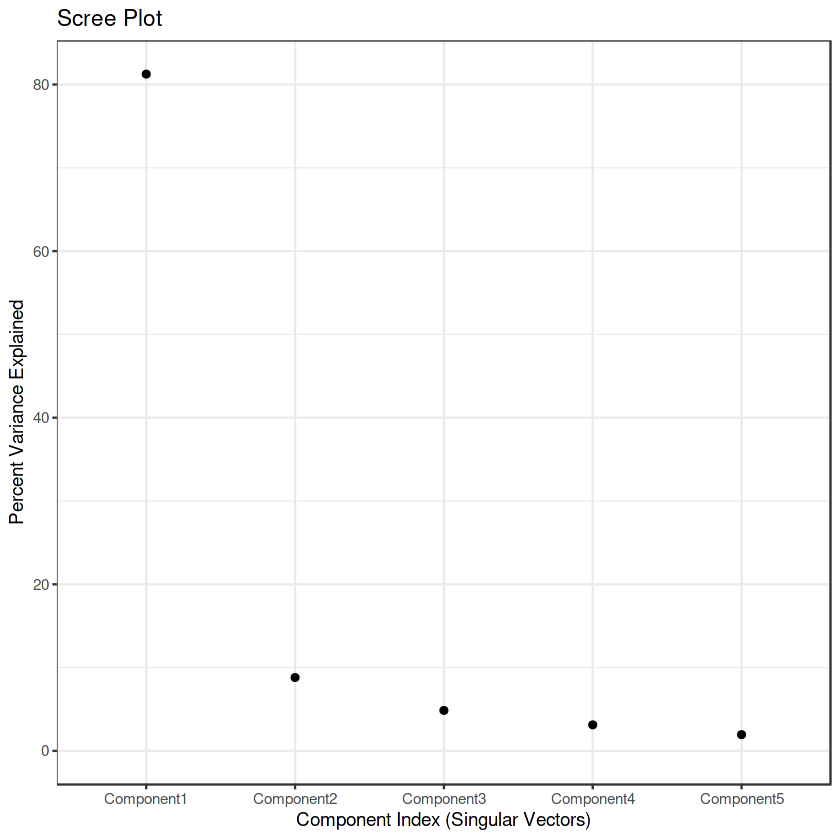

Sample_Well Sample_Group Slide        Array        X_        Sample_Name.y
[1,] 0.1632860   0.7653361    4.825375e-01 0.4775377209 0.6106468 0.6106468    
[2,] 0.1621387   0.5363894    3.364738e-01 0.0062349319 0.4520163 0.4520163    
[3,] 0.2019286   0.2584915    5.379506e-01 0.0002027719 0.4307047 0.4307047    
[4,] 0.1694838   0.1724151    9.787018e-01 0.0848477889 0.4998877 0.4998877    
[5,] 0.9466838   0.9490019    5.868505e-07 0.6962391415 0.4345051 0.4345051    
     Container Position  concentration__ng_ul_ Qubit_Conc__Reading__ng_ul_
[1,] 0.3128035 0.6199333 0.6087950             0.29431548                 
[2,] 0.5330044 0.4529056 0.5976983             0.02503869                 
[3,] 0.2469490 0.4291533 0.3448596             0.40487452                 
[4,] 0.1377165 0.5063799 0.6538951             0.76563385                 
[5,] 0.8586273 0.4333853 0.3401355             0.37829344                 
     After_dilution__ng_ul_ DNA_vol___ul_ Water_vol___ul_ case     
[1,] 0.08449947             2.187351e-07  2.187351e-07    0.7653361
[2,] 0.02839281             3.162915e-01  3.162915e-01    0.5363894
[3,] 0.50787414             3.813433e-01  3.813433e-01    0.2584915
[4,] 0.93434375             5.097486e-02  5.097486e-02    0.1724151
[5,] 0.21675516             2.524949e-01  2.524949e-01    0.9490019
     Plate_Position Plate__      batch_id    
[1,] 0.2568549      5.377705e-01 8.928459e-01
[2,] 0.1712899      5.996522e-01 5.594106e-01
[3,] 0.2016207      4.377842e-01 5.900139e-01
[4,] 0.1891522      8.910856e-01 8.928459e-01
[5,] 0.9421542      2.890326e-06 7.117887e-06

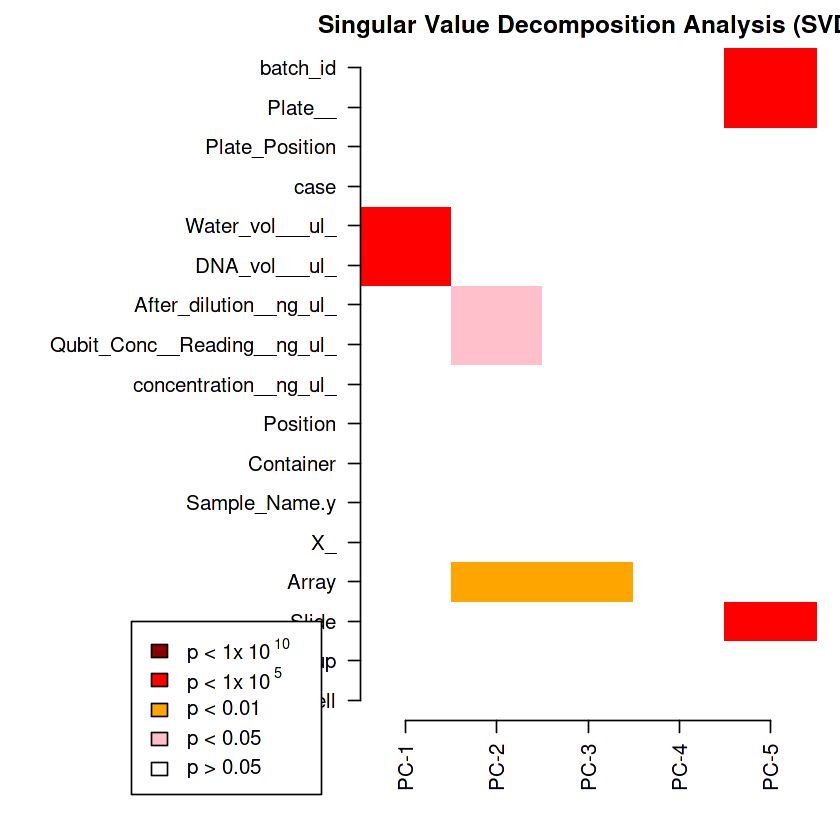

In [11]:
champ.SVD(beta = myNorm,
              #rgSet=myLoad$rgSet,
              pd=myLoad$pd,
              RGEffect=TRUE,
              PDFplot=TRUE,
              Rplot=TRUE,
              resultsDir="./CHAMP_SVDimages/")

# Correct for batch effect
ComBat algorithm uses an empirical Bayes method to correct for technical variation. If ComBat were applied directly to beta values, the output may not be bounded between 0 and 1. For this reason ChAMP logit transforms beta values before ComBat adjustment and then computes the reverse logit transformation following the ComBat adjustment. If the user has chosen to use M-values, please assign logitTrans=FALSE.

In [12]:
myCombat<- champ.runCombat(beta=myNorm,
                    pd=myLoad$pd,
                    variablename="Sample_Group",
                    batchname=c("Slide"),
                    logitTrans=TRUE)


[===========================]

[<< CHAMP.RUNCOMBAT START >>]

-----------------------------

<< Preparing files for ComBat >>

[Combat correction will be proceed with 817988 probes and 47 samples.]


<< Following Factors in your pd(sample_sheet.csv) could be applied to Combat: >>

<Slide>(character):205852200117, 205852200128, 205852200126, 205689130080, 205852200157, 205689130086

<Array>(character):R01C01, R08C01, R07C01, R04C01, R06C01, R05C01, R02C01, R03C01

<Container>(character):Box 1, Box 2, NA

<case>(character):Case, Control

<Plate__>(character):Plate 1, Plate 2

<batch_id>(character):1, 0

[champ.runCombat have automatically select ALL factors contain at least two different values from your pd(sample_sheet.csv).]


<< Following Factors in your pd(sample_sheet.csv) can not be corrected: >>

<Sample_Name>

<Sample_Well>

<Sample_Plate>

<Sample_Group>

<Pool_ID>

<X_>

<Sample_Folder>

<Sample_Name.y>

<Position>

<concentration__ng_ul_>

<Qubit_Conc__Reading__ng_ul_>

<After

~Sample_Group
<environment: 0x55dd798df188>


Generate mod success. Started to run ComBat, which is quite slow...

Found6batches

Adjusting for1covariate(s) or covariate level(s)

Standardizing Data across genes

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting the Data


champ.runCombat success. Corrected dataset will be returned.



In [13]:
head(myCombat)

U1154       U12        U132       U133       U1343      U144      
cg07881041 0.937941300 0.95758408 0.94138839 0.96581255 0.94233642 0.94919625
cg23229610 0.968476335 0.95833368 0.96897169 0.95315999 0.97545175 0.95730200
cg03513874 0.944555827 0.94907480 0.93846146 0.96880555 0.96524343 0.95568946
cg05451842 0.010921416 0.02026230 0.01929692 0.02332934 0.02888645 0.01098441
cg14797042 0.756121796 0.60912090 0.84052431 0.84519097 0.80116199 0.68978045
cg09838562 0.009612374 0.03001345 0.01528700 0.02626112 0.01661630 0.01317599
           U156       U16        U167       U175       ⋯ U63        U64       
cg07881041 0.94212137 0.95387830 0.94051834 0.93833532 ⋯ 0.96374860 0.94099916
cg23229610 0.96501778 0.94878515 0.93819666 0.96497014 ⋯ 0.94600826 0.97414369
cg03513874 0.94558421 0.93629481 0.91027073 0.95688765 ⋯ 0.95281589 0.94815994
cg05451842 0.01614865 0.01566377 0.01757731 0.01746709 ⋯ 0.01740424 0.01233790
cg14797042 0.88317100 0.69826773 0.30578511 0.84576056 ⋯ 0.78665991 0.72114587
cg09838562 0.01865947 0.02209789 0.01534016 0.01426196 ⋯ 0.03156331 0.01889382
           U654       U711       U712       U789       U83        U845      
cg07881041 0.92734653 0.94353836 0.95180442 0.92033959 0.96037235 0.93205403
cg23229610 0.94607644 0.95606099 0.96269683 0.95084652 0.98020148 0.98082101
cg03513874 0.94628822 0.93492362 0.94397019 0.95495978 0.96038657 0.93028621
cg05451842 0.01492659 0.02084924 0.01148892 0.01243193 0.01126165 0.01560464
cg14797042 0.72502962 0.60759937 0.73196841 0.91954340 0.83476326 0.90435531
cg09838562 0.01035213 0.01572123 0.02463559 0.01433843 0.02407471 0.01662137
           U86        U869      
cg07881041 0.91211921 0.95278936
cg23229610 0.97746590 0.95205471
cg03513874 0.93782427 0.93906253
cg05451842 0.02572508 0.01955087
cg14797042 0.66701209 0.59832877
cg09838562 0.01804430 0.01428586

In [14]:
write.table(myCombat, file = "Normalized_batch_corrected_data.csv", sep=",", row.names=TRUE, col.names=TRUE, quote = FALSE)

# Differential Methylation Analysis
- NOTE: I set p-value correction of "none" because there was nothing significant after correction, so I'm running this just for the sake of code testing. When we have more data we can change it.

champ.DMP() function implements the limma package to calculate the p-value for differential methylation using a linear model. Our latest champ.DMP() function would support numeric variable like age, and categorical variables which contain more than two phenotypes, like “tumor”, “metastasis”, “control”. If our function detected numeric variables like age, linear regression would be conducted on each CpG sites, to find your covariate-related CpGs, say age-related CpGs. While categorical variables detected, champ.DMP() would do contrast comparison between each two phenotypes in your covariate. Say you have covariate as “tumor”, “metastasis”, “control”, then champ.DMP() would compare “tumor–metastatic”, “tumor-control”, and “metastatis-control”. Each comparison would return one data frame containing significantly differential methylated probes.
deltaBeta is the same as logFC

beta	
A matrix of values representing the methylation scores for each sample (M or B). Better to be imputed and normalized data. (default = myNorm)

pheno	
Covariate that you want to do analysis, it might be a categorical vector representing phenotype of factor wish to be analysed, for example "Cancer", "Normal"... Tow or even more phenotypes are allowed. Or it can be a numeric variable like age. (default = myLoad 𝑝𝑑 Sample_Group)

compare.group	
If your pheno is categorical variable, you may specify this parameter to ask champ.DMP() only compare certain two phenotypes. If your pheno contains more than 2 phenotypes, and compare.group is NULL, pairwise comparision would be done between each two phenotypes. You may set the value as compare.group=c("C","T"), it must be a vector contains only two charactor element. (default = NULL)

adjPVal	
The minimum threshold of significance for probes to be considered an DMP. (default = 0.05)

adjust.method	
The p-value adjustment method to be used for the limma analyis, (default= BH (Benjamini-Hochberg))

arraytype	
Choose microarray type is 450K or EPIC. (default = "450K")

In [15]:
myCombat.M <- beta2m(myCombat)
write.table(myCombat.M, file = "Normalized_batch_corrected_data_M.csv", sep=",", row.names=TRUE, col.names=TRUE, quote = FALSE)

In [16]:
head(myCombat.M)

U1154     U12        U132      U133      U1343     U144     
cg07881041  3.917792  4.4967214  4.005532  4.820205  4.030510  4.223700
cg23229610  4.941210  4.5235746  4.964797  4.346905  5.312378  4.486734
cg03513874  4.090528  4.2200701  3.930735  4.956846  4.795535  4.430820
cg05451842 -6.500853 -5.5955259 -5.667374 -5.387655 -5.071175 -6.492464
cg14797042  1.632458  0.6400061  2.397953  2.448788  2.010500  1.152848
cg09838562 -6.686957 -5.0142835 -6.009326 -5.212534 -5.887083 -6.226810
           U156      U16       U167      U175      ⋯ U63       U64      
cg07881041  4.024810  4.370288  3.982939  3.927587 ⋯  4.732548  3.995386
cg23229610  4.785862  4.211447  3.924134  4.783827 ⋯  4.131042  5.235546
cg03513874  4.119109  3.877480  3.342645  4.472176 ⋯  4.335824  4.192991
cg05451842 -5.928955 -5.973648 -5.804558 -5.813795 ⋯ -5.819087 -6.322848
cg14797042  2.918294  1.210511 -1.182864  2.455078 ⋯  1.882585  1.370780
cg09838562 -5.716774 -5.467709 -6.004240 -6.110960 ⋯ -4.939338 -5.698423
           U654      U711      U712      U789      U83       U845     
cg07881041  3.674005  4.062738  4.303693  3.530231  4.599015  3.777954
cg23229610  4.132969  4.443528  4.689711  4.273847  5.629614  5.676391
cg03513874  4.138969  3.844642  4.074475  4.406154  4.599554  3.738159
cg05451842 -6.044275 -5.553464 -6.426942 -6.311758 -6.456098 -5.979191
cg14797042  1.398764  0.630793  1.449378  3.514635  2.336833  3.241133
cg09838562 -6.578916 -5.968281 -5.307126 -6.103133 -5.341180 -5.886636
           U86       U869      
cg07881041  3.375603  4.3349734
cg23229610  5.438865  4.3115834
cg03513874  3.914894  3.9458198
cg05451842 -5.243082 -5.6481381
cg14797042  1.002243  0.5749233
cg09838562 -5.766043 -6.1085091

In [17]:
myDMP <- champ.DMP(beta = myCombat,
              pheno = myLoad$pd$Sample_Group,
              compare.group = c("Control", "Case"),
              adjPVal = 1, #0.05
              adjust.method = "fdr", #BH, fdr
              arraytype = "EPIC")

write.table(myDMP[[1]], file = "DMP_results.csv", sep=",", row.names=TRUE, col.names=TRUE, quote = TRUE)

[===========================]

[<<<<< ChAMP.DMP START >>>>>]

-----------------------------

!!! Important !!! New Modification has been made on champ.DMP(): 


    (1): In this version champ.DMP() if your pheno parameter contains more than two groups of phenotypes, champ.DMP() would do pairewise differential methylated analysis between each pair of them. But you can also specify compare.group to only do comparasion between any two of them.


    (2): champ.DMP() now support numeric as pheno, and will do linear regression on them. So covariates like age could be inputted in this function. You need to make sure your inputted "pheno" parameter is "numeric" type.


--------------------------------


[ Section 1:  Check Input Pheno Start ]


  You pheno is character type.

    Your pheno information contains following groups. >>

    <Case>:25 samples.

    <Control>:22 samples.

    [The power of statistics analysis on groups contain very few samples may not strong.]

    pheno contains o

          Contrasts
Levels     pControl-pCase
  pCase                -1
  pControl              1


  You have found 817988 significant MVPs with a fdr adjusted P-value below 1.

  Calculate DMP for Case and Control done.


[ Section 2:  Find Numeric Vector Related CpGs Done ]



[ Section 3:  Match Annotation Start ]



[ Section 3:  Match Annotation Done ]


[<<<<<< ChAMP.DMP END >>>>>>]

[===========================]

[You may want to process DMP.GUI() or champ.GSEA() next.]




In [18]:
myDMP.M <- champ.DMP(beta = myCombat.M,
              pheno = myLoad$pd$Sample_Group,
              compare.group = c("Control", "Case"),
              adjPVal = 1, #0.05
              adjust.method = "fdr", #BH, fdr
              arraytype = "EPIC")

write.table(myDMP.M[[1]], file = "DMP_results_M.csv", sep=",", row.names=TRUE, col.names=TRUE, quote = TRUE)

[===========================]

[<<<<< ChAMP.DMP START >>>>>]

-----------------------------

!!! Important !!! New Modification has been made on champ.DMP(): 


    (1): In this version champ.DMP() if your pheno parameter contains more than two groups of phenotypes, champ.DMP() would do pairewise differential methylated analysis between each pair of them. But you can also specify compare.group to only do comparasion between any two of them.


    (2): champ.DMP() now support numeric as pheno, and will do linear regression on them. So covariates like age could be inputted in this function. You need to make sure your inputted "pheno" parameter is "numeric" type.


--------------------------------


[ Section 1:  Check Input Pheno Start ]


  You pheno is character type.

    Your pheno information contains following groups. >>

    <Case>:25 samples.

    <Control>:22 samples.

    [The power of statistics analysis on groups contain very few samples may not strong.]

    pheno contains o

          Contrasts
Levels     pControl-pCase
  pCase                -1
  pControl              1


  You have found 817988 significant MVPs with a fdr adjusted P-value below 1.

  Calculate DMP for Case and Control done.


[ Section 2:  Find Numeric Vector Related CpGs Done ]



[ Section 3:  Match Annotation Start ]



[ Section 3:  Match Annotation Done ]


[<<<<<< ChAMP.DMP END >>>>>>]

[===========================]

[You may want to process DMP.GUI() or champ.GSEA() next.]




In [19]:
head(myDMP[[1]])

logFC        AveExpr    t         P.Value      adj.P.Val B       
cg11693508 -0.055019532 0.28770324 -6.222992 1.311946e-07 0.0813448 6.615789
cg08896901  0.477635384 0.54982371  6.017138 2.677006e-07 0.0813448 5.907093
cg21132779 -0.009121484 0.01772557 -5.985824 2.983349e-07 0.0813448 5.799519
cg15116327  0.013616726 0.95660863  5.765360 6.388035e-07 0.1306334 5.044309
cg10948895  0.027716239 0.88789195  5.642873 9.738515e-07 0.1593198 4.626654
cg23447960  0.015188417 0.94329401  5.503082 1.573428e-06 0.2145076 4.152017
           Case_AVG  Control_AVG deltaBeta    CHR MAPINFO   Strand Type gene  
cg11693508 0.3134571 0.25843753  -0.055019532 17   37793320 R      I    STARD3
cg08896901 0.3262497 0.80388509   0.477635384 4   152996165 F      II         
cg21132779 0.0219952 0.01287371  -0.009121484 6    33359789 R      I    KIFC1 
cg15116327 0.9502348 0.96385157   0.013616726 1    32741619 R      I    LCK   
cg10948895 0.8749184 0.90263463   0.027716239 16   79522444 F      II         
cg23447960 0.9361845 0.95137296   0.015188417 20   60588111 R      II   TAF4  
           feature cgi     feat.cgi      UCSC_Islands_Name      
cg11693508 TSS200  island  TSS200-island chr17:37793265-37793722
cg08896901 IGR     opensea IGR-opensea                          
cg21132779 Body    island  Body-island   chr6:33359097-33359975 
cg15116327 Body    shore   Body-shore    chr1:32740710-32741544 
cg10948895 IGR     opensea IGR-opensea                          
cg23447960 Body    shore   Body-shore    chr20:60587264-60587488
           SNP_ID                                          SNP_DISTANCE
cg11693508                                                             
cg08896901 rs7656970;rs72953014;rs193300188;rs564493111    1;17;22;32  
cg21132779 rs200816546                                     41          
cg15116327 rs539280346                                     29          
cg10948895 rs140732858;rs562664660;rs533295533;rs551687404 1;5;10;13   
cg23447960 rs527645843;rs549654376;rs561471123             40;9;2

In [20]:
head(myDMP.M[[1]])

logFC      AveExpr    t         P.Value      adj.P.Val B       
cg08896901  4.1724561  0.6619374  6.553360 3.296032e-08 0.0163036 6.919229
cg21132779 -0.8336997 -5.9030048 -6.500002 3.986269e-08 0.0163036 6.779481
cg15116327  0.4959100  4.5045409  5.864597 3.807754e-07 0.1038232 5.103673
cg17965019 -0.4411680 -5.7956082 -5.734244 6.031970e-07 0.1127957 4.758434
cg11693508 -0.3946126 -1.3206436 -5.696288 6.894703e-07 0.1127957 4.657898
cg00909110  0.6212641  3.7362307  5.590219 1.001015e-06 0.1151686 4.376998
           Case_AVG  Control_AVG deltaBeta  CHR MAPINFO   Strand Type gene    
cg08896901 -1.291127  2.881329    4.1724561 4   152996165 F      II           
cg21132779 -5.512762 -6.346462   -0.8336997 6    33359789 R      I    KIFC1   
cg15116327  4.272413  4.768323    0.4959100 1    32741619 R      I    LCK     
cg17965019 -5.589104 -6.030272   -0.4411680 6    27858545 F      II   HIST1H3J
cg11693508 -1.135931 -1.530544   -0.3946126 17   37793320 R      I    STARD3  
cg00909110  3.445426  4.066690    0.6212641 8    10427797 F      II           
           feature cgi     feat.cgi       UCSC_Islands_Name      
cg08896901 IGR     opensea IGR-opensea                           
cg21132779 Body    island  Body-island    chr6:33359097-33359975 
cg15116327 Body    shore   Body-shore     chr1:32740710-32741544 
cg17965019 1stExon island  1stExon-island chr6:27858166-27858564 
cg11693508 TSS200  island  TSS200-island  chr17:37793265-37793722
cg00909110 IGR     opensea IGR-opensea                           
           SNP_ID                                                     
cg08896901 rs7656970;rs72953014;rs193300188;rs564493111               
cg21132779 rs200816546                                                
cg15116327 rs539280346                                                
cg17965019 rs570738671                                                
cg11693508                                                            
cg00909110 rs571776132;rs139495372;rs111452533;rs577225622;rs192035931
           SNP_DISTANCE
cg08896901 1;17;22;32  
cg21132779 41          
cg15116327 29          
cg17965019 31          
cg11693508             
cg00909110 1;5;13;31;47

# Applying Bumphunter, DMRcate or ProbeLasso Algorithms to detect Different Methylation Regions in a beta valued Methylation Dataset.
## Description
Applying Bumphunter, DMRcate or ProbeLasso Algorithms to Estimate regions for which a genomic profile deviates from its baseline value. Originally implemented to detect differentially methylated genomic regions between two populations. By default, we recommend user do champ.DMR on normalized beta value on two populations, like case to control. The function will return detected DMR and estimated p value. The three algorithms specified in this function is different, while Bumphunter and DMRcate calcuated averaged candidate bumps methylation value between case and control. Thus parameters is different for three algorithms. Note that the result of champ.DMR() would be used as inpute of champ.GSEA() function, thus we suggest user not change the internal structure of the result of champ.DMR() function.

In [21]:
myDMR <- champ.DMR(beta=myCombat, #Beta is ok because Bumphunter will already convert it to M, see documentation
              pheno=myLoad$pd$Sample_Group,
              compare.group=c("Control","Case"),
              arraytype="EPIC",
              method = "Bumphunter", #already converts to M
              minProbes=7,
              adjPvalDmr=1,
              cores=8,
              ## following parameters are specifically for Bumphunter method.
              maxGap=300,
              cutoff=NULL,
              pickCutoff=TRUE,
              smooth=TRUE,
              smoothFunction=loessByCluster,
              useWeights=FALSE,
              permutations=NULL,
              B=250,
              nullMethod="bootstrap",
              #
              Rplot=T,
              PDFplot=T,
              resultsDir="./CHAMP_ProbeLasso/"
         )

write.table(myDMR$BumphunterDMR, file = "DMR_results.csv", sep=",", row.names=TRUE, col.names=TRUE, quote = TRUE)

[===========================]

[<<<<< ChAMP.DMR START >>>>>]

-----------------------------

!!! important !!! We just upgrate champ.DMR() function, since now champ.DMP() could works on multiple phenotypes, but ProbeLasso can only works on one DMP result, so if your pheno parameter contains more than 2 phenotypes, and you want to use ProbeLasso function, you MUST specify compare.group=c("A","B"). Bumphunter and DMRcate should not be influenced.


[ Section 1:  Check Input Pheno Start ]


  You pheno is character type.

    Your pheno information contains following groups. >>

    <Case>:25 samples.

    <Control>:22 samples.


[ Section 1:  Check Input Pheno Done ]



[ Section 2:  Run DMR Algorithm Start ]


Loading required package: IlluminaHumanMethylationEPICanno.ilm10b4.hg19

<< Find DMR with Bumphunter Method >>

8 cores will be used to do parallel Bumphunter computing.

According to your data set, champ.DMR() detected 11997 clusters contains MORE THAN 7 probes within300 maxGap. 

## Interpreting DMR
1)      value:  Mean value of all smooth coef in one candidate bump.

2)      L: Numbers of CpGs contained in candidate bump.

3)      p.value:  Proportion of random bumps show most CpGs and higher mean value then this DMR.

4)      fwer:  Proportion that a random run would generate one such DMR shows most CpGs and higher mean value.

5)      p.valueArea:  Proportion of random bumps show higher abs sum value then this DMR.

6)      fwerArea: Proportion that a random run would generate one such DMR show higher abs sum value.

In [22]:
head(myDMR$BumphunterDMR)

seqnames start     end       width strand value     area     cluster
DMR_1 chr6      33091242  33092130 888   *      0.4490073 7.633124 396851 
DMR_2 chr2        731073    731594 521   *      0.7103862 6.393475 240848 
DMR_3 chr1      17004633  17004834 201   *      0.6597609 3.298805   6474 
DMR_4 chr3     195489708 195490309 601   *      0.6239099 4.991279 339374 
DMR_5 chr1     205818956 205819609 653   *      0.4858678 5.830414  38500 
DMR_6 chr5     135415693 135416613 920   *      0.3101875 4.342625 379325 
      indexStart indexEnd L  clusterL p.value      fwer  p.valueArea fwerArea
DMR_1 122596     122612   17 25       0.0008364368 0.360 0.002794761 0.700   
DMR_2  76044      76052    9  9       0.0010488652 0.464 0.004859299 0.848   
DMR_3   1690       1694    5  8       0.0020645384 0.660 0.038223833 1.000   
DMR_4 101849     101856    8  8       0.0024030961 0.676 0.011198959 0.964   
DMR_5  12370      12381   12 14       0.0024893952 0.688 0.006598557 0.884   
DMR_6 112240     112253   14 14       0.0050916429 0.784 0.017963476 0.992

# Enrichment Analysis
After previous steps, you may already get some significant DMPs or DMRs, thus you may want to know if genes involved in these significant DMPs or DMRs are enriched for specific biological terms or pathways. To achieve this analysis, you can use champ.GSEA() to do GSEA analysis.

[===========================]

[<<<< ChAMP.GSEA START >>>>>]

-----------------------------

<< Prepare CpG List Ready  >>

  Calculating GSEA with gometh method on DMP CpG list

  Note that gometh method would count numbers of CpGs in each genes and correct this bias.

All input CpGs are used for testing.

  Calculating GSEA with gometh method on DMR CpG list

  Note that gometh method would count numbers of CpGs in each genes and correct this bias.

All input CpGs are used for testing.

[<<<<< ChAMP.GSEA END >>>>>>]

[===========================]



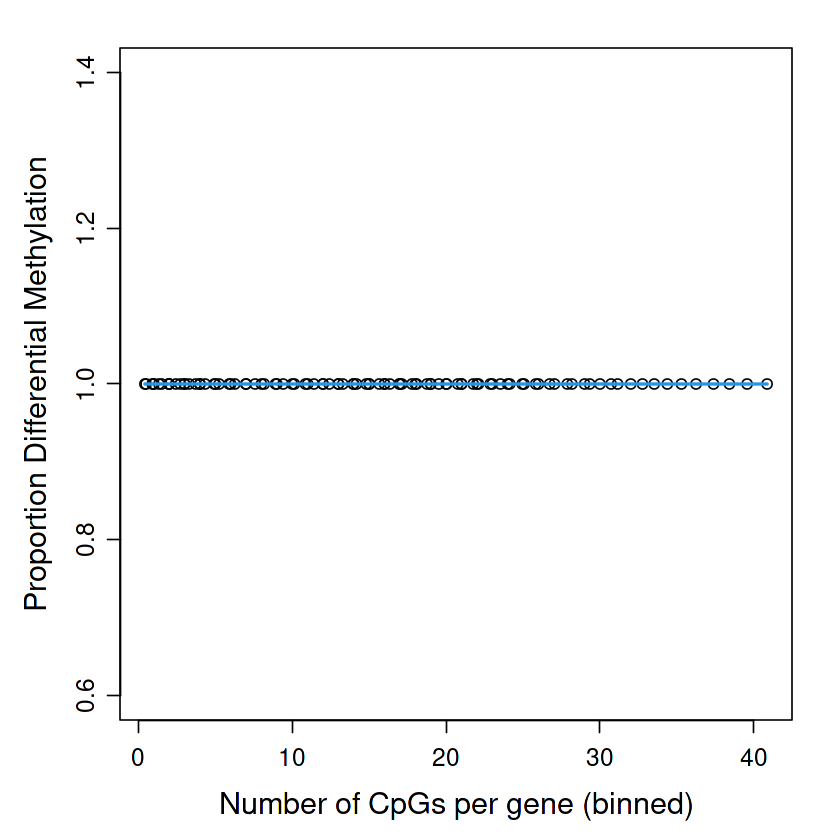

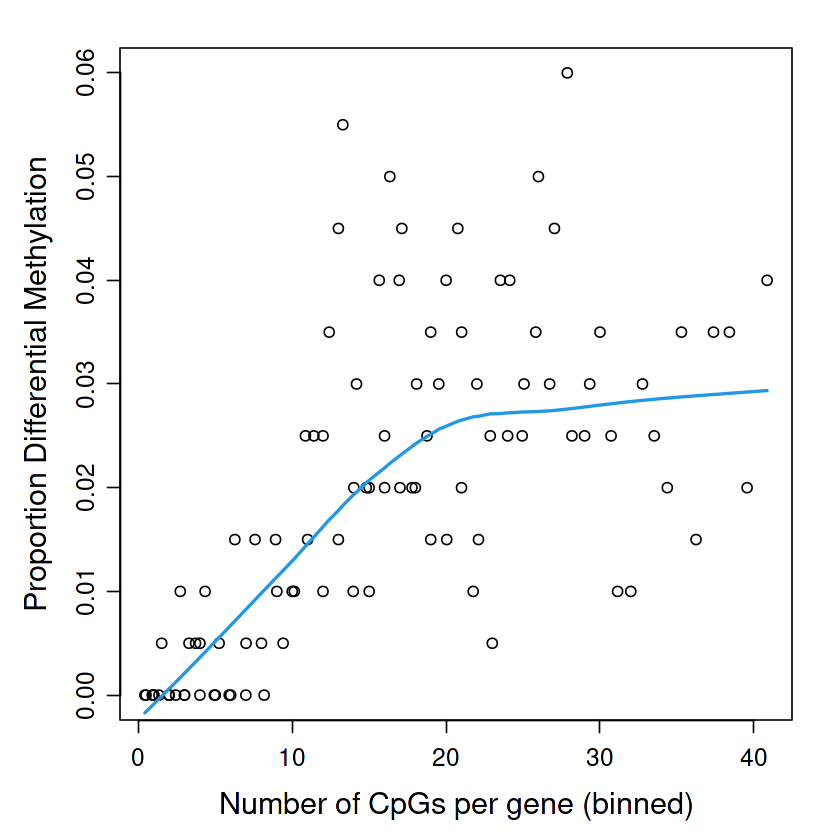

In [23]:
myGSEA <- champ.GSEA(beta=myCombat,
               DMP=myDMP[[1]],
               DMR=myDMR,
               CpGlist=NULL,
               Genelist=NULL,
               pheno=myLoad$pd$Sample_Group,
               method="gometh",
               arraytype="EPIC",
               Rplot=TRUE,
               adjPval=0.25,
               cores=8)

[===========================]

[<<<< ChAMP.GSEA START >>>>>]

-----------------------------

<< Prepare CpG List Ready  >>

  Calculating GSEA with gometh method on DMP CpG list

  Note that gometh method would count numbers of CpGs in each genes and correct this bias.

All input CpGs are used for testing.

  Calculating GSEA with gometh method on DMR CpG list

  Note that gometh method would count numbers of CpGs in each genes and correct this bias.

All input CpGs are used for testing.

[<<<<< ChAMP.GSEA END >>>>>>]

[===========================]



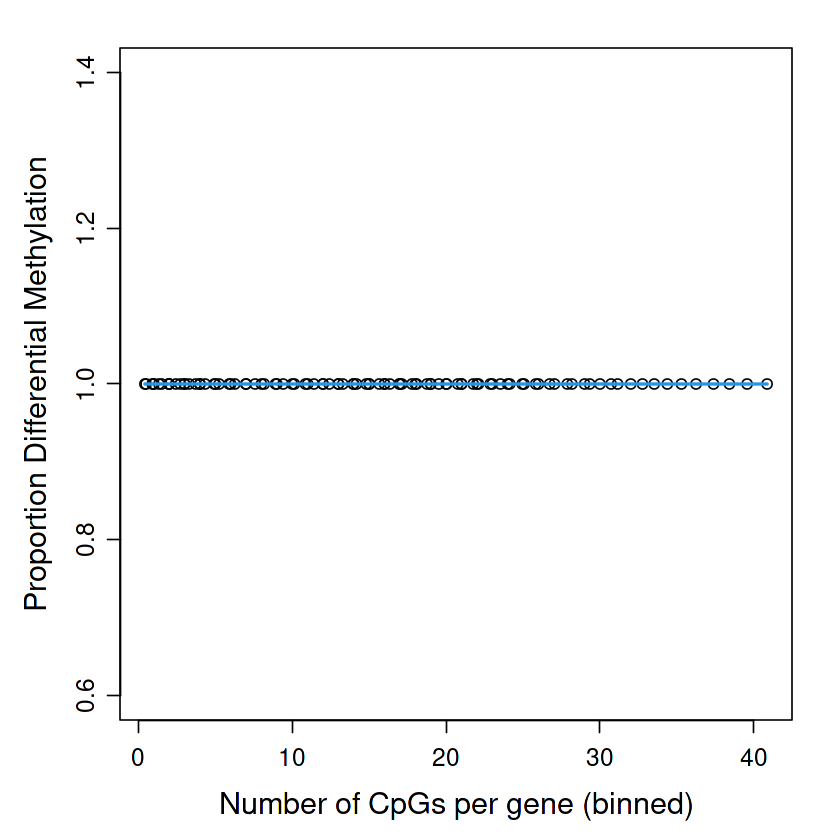

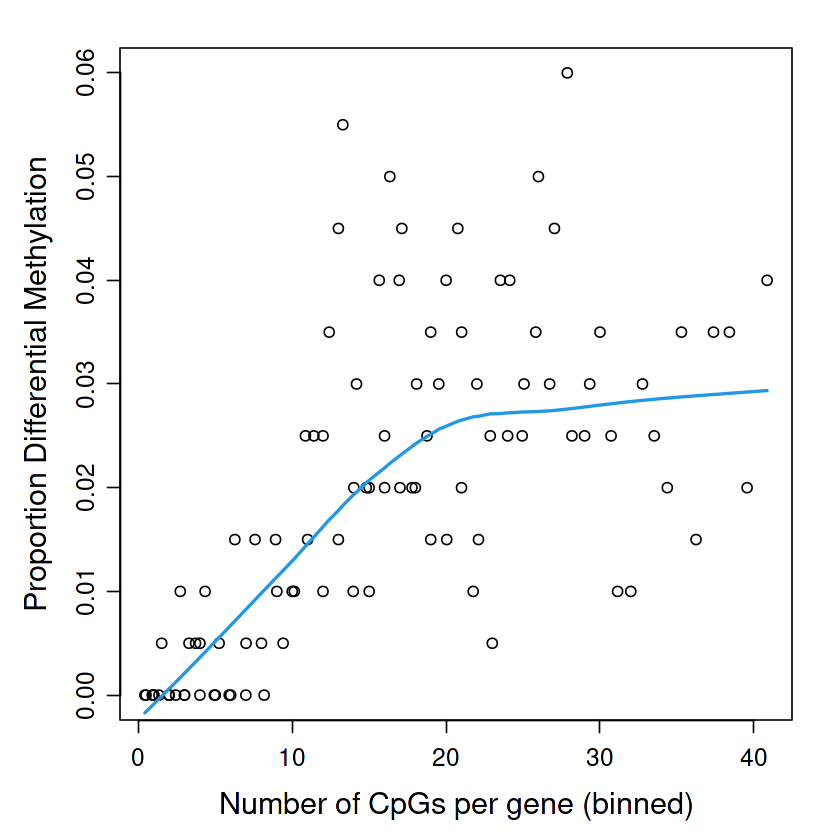

In [24]:
myGSEA.M <- champ.GSEA(beta=myCombat.M,
               DMP=myDMP.M[[1]],
               DMR=myDMR,
               CpGlist=NULL,
               Genelist=NULL,
               pheno=myLoad$pd$Sample_Group,
               method="gometh",
               arraytype="EPIC",
               Rplot=TRUE,
               adjPval=0.25,
               cores=8)

In [25]:
head(myGSEA$DMP)
head(myGSEA$DMR)

ONTOLOGY TERM N DE P.DE FDR

ONTOLOGY TERM N DE P.DE FDR

In [26]:
head(myGSEA.M$DMP)
head(myGSEA.M$DMR)

ONTOLOGY TERM N DE P.DE FDR

ONTOLOGY TERM N DE P.DE FDR

In [27]:
write.table(myGSEA$DMP, file = "GSEA_DMP_results_gometh.csv", sep=",", row.names=FALSE, col.names=TRUE, quote = TRUE)
write.table(myGSEA$DMR, file = "GSEA_DMR_results_gometh.csv", sep=",", row.names=FALSE, col.names=TRUE, quote = TRUE)
write.table(myGSEA.M$DMP, file = "GSEA_DMP_results_gometh_M.csv", sep=",", row.names=FALSE, col.names=TRUE, quote = TRUE)
write.table(myGSEA.M$DMR, file = "GSEA_DMR_results_gometh_M.csv", sep=",", row.names=FALSE, col.names=TRUE, quote = TRUE)

In [28]:
myGSEA <- champ.GSEA(beta=myCombat,
               DMP=myDMP[[1]],
               DMR=myDMR,
               CpGlist=NULL,
               Genelist=NULL,
               pheno=myLoad$pd$Sample_Group,
               method="fisher",
               arraytype="EPIC",
               Rplot=TRUE,
               adjPval=0.25,
               cores=8)
myGSEA.M <- champ.GSEA(beta=myCombat.M,
               DMP=myDMP.M[[1]],
               DMR=myDMR,
               CpGlist=NULL,
               Genelist=NULL,
               pheno=myLoad$pd$Sample_Group,
               method="fisher",
               arraytype="EPIC",
               Rplot=TRUE,
               adjPval=0.25,
               cores=8)

[===========================]

[<<<< ChAMP.GSEA START >>>>>]

-----------------------------

<< Prepare Gene List Ready  >>

<< Start Do GSEA on each Gene List  >>

<< Do GSEA on Gene list DMP>>

<< Pale Fisher Exact Test will be used to do GSEA >>

 << The category information is downloaded from MsigDB, and only simple Fisher Exact Test will be used to calculate GSEA. This method is suitable if your genes has equalivalent probability to be enriched. If you are using CpGs mapping genes, gometh method is recommended.>> 

<< Done for Gene list DMP >>

<< Do GSEA on Gene list DMR>>

<< Pale Fisher Exact Test will be used to do GSEA >>

 << The category information is downloaded from MsigDB, and only simple Fisher Exact Test will be used to calculate GSEA. This method is suitable if your genes has equalivalent probability to be enriched. If you are using CpGs mapping genes, gometh method is recommended.>> 

<< Done for Gene list DMR >>

[<<<<< ChAMP.GSEA END >>>>>>]

[=====================

In [29]:
write.table(myGSEA$DMP, file = "GSEA_DMP_results_fisher.csv", sep=",", row.names=FALSE, col.names=TRUE, quote = TRUE)
write.table(myGSEA$DMR, file = "GSEA_DMR_results_fisher.csv", sep=",", row.names=FALSE, col.names=TRUE, quote = TRUE)
write.table(myGSEA.M$DMP, file = "GSEA_DMP_results_fisher_M.csv", sep=",", row.names=FALSE, col.names=TRUE, quote = TRUE)
write.table(myGSEA.M$DMR, file = "GSEA_DMR_results_fisher_M.csv", sep=",", row.names=FALSE, col.names=TRUE, quote = TRUE)

In [30]:
myebayGSEA <- champ.ebGSEA(beta=myCombat,
                           pheno=myLoad$pd$Sample_Group,
                           arraytype="EPIC", 
                           minN=5, 
                           adjPval=0.25,
                           cores=8
                          )

ebGSEA function require no NA in beta and pheno parameter.


[ Section 1:  Generate Annotation Start ]


  Extracting annotation from IlluminaHumanMethylationEPICilm10b4.hg19.

  Removing Non-CG probes out of annotation.

  Flat all genes on each CpG.

  Removing all duplicated CpG-genes.

  Annotation Prepared.


[ Section 1:  Generate Annotation Done ]



[ Section 2:  Running Global Test Start ]


  Applying Binary Model on Global Test. It could be very slow...


[ Section 2:  Running Global Test Done ]



[ Section 3:  GSEA on Pathway Start ]


  Loading MsigDB PathwayList information.

  Doing Wilcox Test and Known Population Median Test, it could be slow here.

8 cores will be used to do parallel GSEA computing.

  Adjusting Pathway P value with BH method.

  Your adjPval is 0.25, only pathway below BH adjusted P value 0.05 would be returned.

  Forming up final result.


[ Section 3:  GSEA on Pathway Done ]




In [31]:
myebayGSEA.M <- champ.ebGSEA(beta=myCombat.M,
                           pheno=myLoad$pd$Sample_Group,
                           arraytype="EPIC", 
                           minN=5, 
                           adjPval=0.25,
                           cores=8
                          )

ebGSEA function require no NA in beta and pheno parameter.


[ Section 1:  Generate Annotation Start ]


  Extracting annotation from IlluminaHumanMethylationEPICilm10b4.hg19.

  Removing Non-CG probes out of annotation.

  Flat all genes on each CpG.

  Removing all duplicated CpG-genes.

  Annotation Prepared.


[ Section 1:  Generate Annotation Done ]



[ Section 2:  Running Global Test Start ]


  Applying Binary Model on Global Test. It could be very slow...


[ Section 2:  Running Global Test Done ]



[ Section 3:  GSEA on Pathway Start ]


  Loading MsigDB PathwayList information.

  Doing Wilcox Test and Known Population Median Test, it could be slow here.

8 cores will be used to do parallel GSEA computing.

  Adjusting Pathway P value with BH method.

  Your adjPval is 0.25, only pathway below BH adjusted P value 0.05 would be returned.

  Forming up final result.


[ Section 3:  GSEA on Pathway Done ]




In [32]:
write.table(myebayGSEA$GSEA$`Rank(P)`, file = "ebGSEA_rank_P.csv", sep=",", row.names=TRUE, col.names=TRUE, quote = TRUE)
write.table(myebayGSEA$GSEA$`Rank(AUC)`, file = "ebGSEA_rank_AUC.csv", sep=",", row.names=TRUE, col.names=TRUE, quote = TRUE)
write.table(myebayGSEA$gtResult, file = "ebGSEA_gtResult.csv", sep=",", row.names=TRUE, col.names=TRUE, quote = TRUE)


In [34]:
sum(myebayGSEA$GSEA$`Rank(P)`[,'adjP']<=0.05)

ERROR: Error in myebayGSEA$GSEA$`Rank(P)`[, "adjP"]: incorrect number of dimensions


In [35]:
sum(myebayGSEA$GSEA$`Rank(P)`[,'adjP']<=0.25)

ERROR: Error in myebayGSEA$GSEA$`Rank(P)`[, "adjP"]: incorrect number of dimensions


In [36]:
sum(myebayGSEA$GSEA$`Rank(AUC)`[,'P(KPMT)']<=0.05)

ERROR: Error in myebayGSEA$GSEA$`Rank(AUC)`[, "P(KPMT)"]: incorrect number of dimensions


In [37]:
sum(myebayGSEA$GSEA$`Rank(AUC)`[,'P']<=0.05)

ERROR: Error in myebayGSEA$GSEA$`Rank(AUC)`[, "P"]: incorrect number of dimensions


In [38]:
sum(myebayGSEA$GSEA$`Rank(AUC)`[,'P']<=0.25)

ERROR: Error in myebayGSEA$GSEA$`Rank(AUC)`[, "P"]: incorrect number of dimensions


In [39]:
head(myebayGSEA$GSEA)

$`Rank(P)`
        nREP          AUC        P(WT)      P(KPMT)         adjP 
4.400000e+01 7.077916e-01 9.208325e-07 1.695777e-05 7.888772e-03 

$`Rank(AUC)`
        nREP          AUC        P(WT)      P(KPMT)         adjP 
4.400000e+01 7.077916e-01 9.208325e-07 1.695777e-05 7.888772e-03 

$POI
[1] "ACCAATC,MIR-509"

In [40]:
myebayGSEA$gtResult

p-value      Statistic    Expected Std.dev  #Cov
MIR5787      0.0002164216 20.537843    2.173913 2.359980  3  
LOC441155    0.0002712811 16.553444    2.173913 2.014580  3  
DBF4         0.0004956361 12.111666    2.173913 1.499266 21  
ZNF716       0.0005408553  9.602370    2.173913 1.224123 12  
CCT6P3       0.0005580047 11.583507    2.173913 1.655776  7  
RPL22L1      0.0006344008 10.457056    2.173913 1.467398 16  
LOC100132781 0.0007655713 22.459560    2.173913 3.040777  1  
MIR4757      0.0008677981 16.505797    2.173913 2.331582  2  
ZEB1-AS1     0.0008957703 21.950396    2.173913 3.040777  1  
BPIFB2       0.0009590433 18.026353    2.173913 2.495517 12  
RPS27        0.0011758395  9.436486    2.173913 1.373595 15  
SHISAL2B     0.0012589736  7.855140    2.173913 1.184198 16  
ALG1L        0.0012903044 19.260631    2.173913 2.798717  5  
PDZRN4       0.0014746340 11.158209    2.173913 1.630858 54  
CST3         0.0014919284  9.206241    2.173913 1.396561 11  
MIR6736      0.0015583947 20.135864    2.173913 3.040777  1  
NEBL-AS1     0.0016039499 11.555887    2.173913 1.765636  6  
MAFG-DT      0.0016266621 19.994137    2.173913 3.040777  1  
WASHC2A      0.0017502728 13.491496    2.173913 2.199358  2  
GFY          0.0018357426 10.743477    2.173913 1.708097  9  
SERHL        0.0018397631  9.210367    2.173913 1.450271 14  
SNORD41      0.0018966231  8.676325    2.173913 1.363444  9  
FAM66C       0.0019327146 11.500880    2.173913 1.902968 11  
MIR6855      0.0021402222 19.083080    2.173913 3.040777  1  
FST          0.0021446513  7.455471    2.173913 1.201374 17  
MIR5006      0.0023945576 18.708257    2.173913 3.040777  1  
ZNF503-AS1   0.0024348611  8.368900    2.173913 1.417290  8  
TOMM7        0.0025374683 13.435188    2.173913 2.127509 13  
MGME1        0.0027572434  9.122581    2.173913 1.588856 28  
RNVU1-20     0.0027810841 12.773832    2.173913 2.170498  4  
⋮            ⋮            ⋮            ⋮        ⋮        ⋮   
PMF1-BGLAP   0.9943775    6.538318e-02 2.173913 2.491633  5  
SEMA3D       0.9944670    4.094416e-01 2.173913 1.574940 19  
MIR519A1     0.9945773    1.466162e-01 2.173913 1.944621  7  
MMP27        0.9945837    5.662303e-02 2.173913 2.088953  6  
CASP8AP2     0.9946672    1.914654e-01 2.173913 1.964693 19  
AMMECR1L     0.9950172    1.660648e-01 2.173913 2.319761 13  
MIR5583-1    0.9955510    6.986678e-05 2.173913 3.040777  1  
CRAT37       0.9955842    5.109563e-02 2.173913 2.439063  4  
MIR197       0.9957066    8.326234e-03 2.173913 2.412861  2  
ANKRD34B     0.9963402    1.188950e-01 2.173913 2.541334 17  
MIR6846      0.9963453    4.714600e-05 2.173913 3.040777  1  
EZR-AS1      0.9964258    5.855099e-02 2.173913 2.637951  6  
LINC01143    0.9965884    7.494028e-03 2.173913 2.201487  2  
MIR6852      0.9967240    5.433573e-03 2.173913 2.596176  2  
PWRN2        0.9968442    3.515188e-05 2.173913 3.040777  1  
BCL6B        0.9968750    2.777111e-01 2.173913 1.680491 19  
CSH2         0.9969225    4.983989e-02 2.173913 2.201279  4  
CLDN12       0.9971481    3.192015e-01 2.173913 1.498720 21  
GRIK1-AS2    0.9972858    3.358951e-02 2.173913 2.543351  4  
LINC01431    0.9973133    7.525919e-02 2.173913 2.396452  5  
LINC00540    0.9973393    5.476482e-03 2.173913 2.319734  2  
IFNLR1       0.9975815    2.930466e-01 2.173913 1.529087 22  
LMO7DN       0.9983398    1.066151e-01 2.173913 2.044405  8  
SERPINB12    0.9984254    8.262993e-02 2.173913 2.001388  7  
RPF2         0.9986881    1.201590e-01 2.173913 2.463240 24  
LINC01450    0.9988873    2.471754e-02 2.173913 2.516199  4  
LOC101929279 0.9990018    5.401638e-03 2.173913 2.854613  3  
USP17L3      0.9992664    1.899606e-06 2.173913 3.040777  1  
MIR1273C     0.9993831    1.343172e-06 2.173913 3.040777  1  
SDHAF2       0.9995817    8.684388e-02 2.173913 2.126244 16

In [41]:
(as.data.frame(do.call(cbind, myebayGSEA$EnrichGene)))
write.table(as.data.frame(do.call(cbind,myebayGSEA$EnrichGene)), file = "ebGSEA_gene_list.csv", sep=",", row.names=FALSE, col.names=TRUE, quote = TRUE)

chr5q23      chr16q24     chr8q24   chr13q11 chr7p21  chr10q23 chr13q13
1    FTMT         SNORD68      KIFC2     SKA3     CBX3     SNCG     ELF1    
2    PRR16        RPL13        LYPD2     ZMYM2    ZNF12    HPSE2    ALG5    
3    MGC32805     TRAPPC2L     ADCY8     FGF9     AGR3     IDE      POSTN   
4    LOC100505841 SLC7A5       ZNF250    XPO4     PSPH     PDLIM1   NBEA    
5    GPX3         ZNF778       HAS2-AS1  SACS     FERD3L   OPALIN   STOML3  
6    CEP120       MC1R         PLEC      ATP12A   BZW2     ANKRD1   CCDC169 
7    GDF9         FOXF1        ZNF251    LATS2    SOSTDC1  MMRN2    WBP4    
8    LOX          LINC00311    KCNK9     GJB2     TWIST1   SMNDC1   SOHLH2  
9    NRG2         DNAAF1       TIGD5     IL17D    CYCS     GHITM    ZAR1L   
10   EGR1         DEF8         ASAP1     CRYL1    VWDE     DNTT     EPSTI1  
11   CDO1         LOC400553    CYHR1     PSPC1    TMEM106B TBC1D12  PROSER1 
12   UBE2B        SPIRE2       DEPTOR    TUBA3C   CRHR2    SLC35G1  EXOSC8  
13   RAD50        ADAD2        ARC       PARP4    SCIN     CH25H    DCLK1   
14   NME5         PRDM7        LRRC6     SKA3     SNX13    RPP30    EEF1DP3 
15   DTWD2        WFDC1        ZHX2      ZMYM2    ARL4A    RGR      FRY     
16   TNFAIP8      PIEZO1       SPATC1    FGF9     DNAH11   POLL     UFM1    
17   SLC27A6      CTU2         EFR3A     XPO4     MYL7     EIF5AL1  KBTBD6  
18   CSNK1G3      DBNDD1       PARP10    SACS     COL28A1  FLJ37201 KBTBD7  
19   ADAMTS2      MVD          CHRAC1    ATP12A   PDE1C    CYP26A1  TRPC4   
20   CSF2         CA5A         FER1L5    LATS2    TSC22D4  TNKS2    CSNK1A1L
21   LMNB1        IL17C        TRMT12    GJB2     AGMO     HHEX     DGKH    
22   CTXN3        LOC100289580 HHLA1     IL17D    PRPS1L1  PLCE1    COG6    
23   SNX2         RNF166       HAS2      CRYL1    C1GALT1  AGAP11   FREM2   
24   PRRC1        GALNS        FBXL6     PSPC1    NDUFA4   ZNF518A  SERTM1  
25   COMMD10      TCF25        EXT1      TUBA3C   IL6      RBP4     MAB21L1 
26   CHSY3        LINC00304    ZNF517    PARP4    ANKMY2   NOC3L    ELF1    
27   PPP2CA       GINS2        ENPP2     SKA3     TSPAN13  SORCS1   ALG5    
28   ZNF474       ZC3H18       RHPN1     ZMYM2    NPVF     FAM25A   POSTN   
29   SNX24        CPNE7        BOP1      FGF9     PHF14    SORCS3   NBEA    
30   ZNF608       MTHFSD       SCRIB     XPO4     PLEKHA8  PPP1R3C  STOML3  
⋮    ⋮            ⋮            ⋮         ⋮        ⋮        ⋮        ⋮       
2571 LMNB1        IL17C        GRINA     CRYL1    PLEKHA8  SLC16A12 DGKH    
2572 CTXN3        LOC100289580 RAD21-AS1 PSPC1    THSD7A   HPS1     COG6    
2573 SNX2         RNF166       FBXO32    TUBA3C   SP8      PTEN     FREM2   
2574 PRRC1        GALNS        MAFA      PARP4    AGR2     SH2D4B   SERTM1  
2575 COMMD10      TCF25        SLC45A4   SKA3     CBX3     PCGF5    MAB21L1 
2576 CHSY3        LINC00304    SLURP1    ZMYM2    ZNF12    CC2D2B   ELF1    
2577 PPP2CA       GINS2        CYC1      FGF9     AGR3     FRAT2    ALG5    
2578 ZNF474       ZC3H18       KCNQ3     XPO4     PSPH     DLG5     POSTN   
2579 SNX24        CPNE7        FAM83A    SACS     FERD3L   MINPP1   NBEA    
2580 ZNF608       MTHFSD       ZFAT      ATP12A   BZW2     LRIT2    STOML3  
2581 FBN2         GAS8         FAM83H    LATS2    SOSTDC1  LRIT1    CCDC169 
2582 PHAX         AFG3L1P      KHDRBS3   GJB2     TWIST1   SLIT1    WBP4    
2583 PGGT1B       SLC22A31     TMEM71    IL17D    CYCS     CFL1P1   SOHLH2  
2584 RNF14        PLCG2        GSDMC     CRYL1    VWDE     ARL3     ZAR1L   
2585 IL4          FBXO31       TMEM75    PSPC1    TMEM106B PANK1    EPSTI1  
2586 IL3          TAF1C        TMEM65    TUBA3C   CRHR2    ANKRD22  PROSER1 
2587 FAM170A      SPG7         DGAT1     PARP4    SCIN     NDUFB8   EXOSC8  
2588 IL5          JPH3         CPSF1     SKA3     SNX13    SORBS1   DCLK1   
2589 CAMLG        ACSF3        NDUFB9    ZMYM2    ARL4A    LIPJ     EEF1DP3 
2590 SLC12A2      CBFA2T3      ASAP1-IT1 FGF9     DNAH11   LIPK     FRY     
2

In [42]:
head(myebayGSEA.M$GSEA)

$`Rank(P)`
                                                                     nREP
REACTOME_CELL_CYCLE                                                   335
ORGANELLE_LUMEN                                                       419
MEMBRANE_ENCLOSED_LUMEN                                               419
REACTOME_MITOTIC_M_M_G1_PHASES                                        154
ORGANELLE_PART                                                       1089
MORF_NME2                                                             140
REACTOME_DNA_REPLICATION                                              174
INTRACELLULAR_ORGANELLE_PART                                         1084
NUCLEAR_LUMEN                                                         353
REACTOME_M_G1_TRANSITION                                               75
REACTOME_ORC1_REMOVAL_FROM_CHROMATIN                                   64
NUCLEAR_PART                                                          527
REACTOME_HOST_INTERACTIONS_OF_HIV_FACTORS                             112
REACTOME_CROSS_PRESENTATION_OF_SOLUBLE_EXOGENOUS_ANTIGENS_ENDOSOMES    45
REACTOME_CELL_CYCLE_CHECKPOINTS                                       109
GINESTIER_BREAST_CANCER_ZNF217_AMPLIFIED_DN                           296
REACTOME_CDK_MEDIATED_PHOSPHORYLATION_AND_REMOVAL_OF_CDC6              45
REACTOME_ASSEMBLY_OF_THE_PRE_REPLICATIVE_COMPLEX                       62
REACTOME_CELL_CYCLE_MITOTIC                                           289
CSR_LATE_UP.V1_UP                                                     155
AGUIRRE_PANCREATIC_CANCER_COPY_NUMBER_UP                              266
REACTOME_HIV_INFECTION                                                177
REACTOME_CDT1_ASSOCIATION_WITH_THE_CDC6_ORC_ORIGIN_COMPLEX             53
REACTOME_AUTODEGRADATION_OF_THE_E3_UBIQUITIN_LIGASE_COP1               45
NIKOLSKY_BREAST_CANCER_12Q24_AMPLICON                                  15
REACTOME_P53_INDEPENDENT_G1_S_DNA_DAMAGE_CHECKPOINT                    47
MORF_RAN                                                              240
REACTOME_G1_S_TRANSITION                                              102
REACTOME_SCF_BETA_TRCP_MEDIATED_DEGRADATION_OF_EMI1                    48
REACTOME_P53_DEPENDENT_G1_DNA_DAMAGE_RESPONSE                          51
REACTOME_SCFSKP2_MEDIATED_DEGRADATION_OF_P27_P21                       52
MIPS_PA700_20S_PA28_COMPLEX                                            35
MODULE_349                                                             17
LINDGREN_BLADDER_CANCER_CLUSTER_3_UP                                  277
GNF2_CENPF                                                             58
MODULE_54                                                             233
REACTOME_REGULATION_OF_APOPTOSIS                                       54
GCM_NF2                                                               264
REACTOME_VIF_MEDIATED_DEGRADATION_OF_APOBEC3G                          46
NUCLEOPLASM_PART                                                      195
MODULE_91                                                              35
chr19p13                                                              484
NUCLEUS                                                              1287
REACTOME_SYNTHESIS_OF_DNA                                              88
MORF_AP2M1                                                            199
REACTOME_DESTABILIZATION_OF_MRNA_BY_AUF1_HNRNP_D0                      49
SCGGAAGY_V$ELK1_02                                                   1052
CAIRO_HEPATOBLASTOMA_CLASSES_UP                                       541
REACTOME_MITOTIC_G1_G1_S_PHASES                                       126
GNF2_CDC2                                                              59
chr14q32                                                              146
ACCAATC,MIR-509                                                        44
REACTOME_SIGNALING_BY_WNT                                          

# Report 01/19/2022

### I reran the whole pipeline with the following changes and considerations:

1) Included batch 1 and batch 2 in the analysis
2) Enable batch correction. Normalization and QC enabled as well with default recommended parameters.
3) Now that we have more samples, I enabled FDR
4) Enabled imputation during data processing step (autoimpute=TRUE)
5) For DMP, I did 2 parallel analyses: one using beta values (like before), the other one using M values (result files using M values are named with *_M.csv suffix).
6) For DMR, according to the DMR function documentation, it already converts beta values to M values if I provide betas as inputs, which is what the authors recommend as best practice. So the previous results we saw for DMR were already using M values.
7) For GSEA, I did 2 parallel analyses: in addition to the default Fisher method, I tested the new gometh method recommended by GSEA. Note that gometh method would count numbers of CpGs in each genes and correct this bias. More reliable, but we may have more trouble to see significant results. For each method I ran GSEA for both DMP and DMR data in parallel.



In [ ]:
sum(myDMP[[1]]$adj.P.Val<=0.05)

In [ ]:
sum(myDMP.M[[1]]$adj.P.Val<=0.05)

In [ ]:
sum(myDMP[[1]]$adj.P.Val<=0.25)

In [ ]:
sum(myDMP.M[[1]]$adj.P.Val<=0.25)

In [ ]:
sum(myDMR$BumphunterDMR$p.value<=0.05)

In [ ]:
sum(myDMR$BumphunterDMR$p.value<=0.25)

In [ ]:
sum(myDMR$BumphunterDMR$p.valueArea<=0.05)

In [ ]:
sum(myDMR$BumphunterDMR$p.valueArea<=0.25)

In [ ]:
sum(myGSEA$DMP$adjPval<=0.05)
sum(myGSEA$DMP$adjPval<=0.25)

In [ ]:
sum(myGSEA$DMR$adjPval<=0.05)
sum(myGSEA$DMR$adjPval<=0.25)

# Report 01/25/2022

## ebGSEA

This is the most recent method for conducting bias-free GSEA from 450K or EPIC data set. This method uses global tests to detect significance of genes from DNA methylation data sets directly, instead of simply selecting genes mapped by DMPs or DMRs. By applying this method, we can find GSEA without bias from uneven numbers of CpGs of genes, and detect some marginal significant genes for the GSEA process. After global test, Empirical Bayes method uses wilcox test to enrich genes to pathways.  

There are three main results: 

- GSEA: contains all pathway's GSEA results in one table (ebGSEA_rank_AUC.csv, without p-value adjustment), and only significant pathways GSEA in another (ebGSEA_rank_P.csv, with p-value adjustment). 
- gtResult: global test result for each gene (ebGSEA_gtResult.csv).
- EnrichedGene: contains enriched genes in each pathway (ebGSEA_gene_list.csv).

Below are the columns for interpreting the bias free GSEA results:

- nREP: Number of genes enriched in this pathway.
- AUC: Area under curve from wilcox test.
- P(WT): P value detected for each pathway from Wilcox Test.
- P(KPMT): P value from Known Population Median Test
- adjP: Adjusted P value for each pathway.

